# Creating Random Forest Figure

## Introduction  

Reproducibility is fundamental to the to the integrity and advancement of our research. Documenting our code ensures that it is reliable, accessible, and allows others to test and verify our results. This will help us build trust and spread our findings with our community partner, ICER. 

In this assignment, we will walk through the steps on how to reproduce our Random Forest Model and our `Predicted vs. Actual QueueTime Random Forest Model` plot. We will only be explaining how to reproduce one model in this assignment, but we will have instructions on how to reproduce every model in our final project.   

This plot illustrates visually the effectiveness of our random forest model and puts into context the error mean absolute error, R^2, and residual mean squared error we used to evaluate the model.

[Link to our INSTALL.md file](https://github.com/tairaeli/ICER_user_data_analytics/blob/main/INSTALL.md)

### Step 1: Preparing your Environment

To start, we need to make sure we have imported all of the Python packages we will be using in our code and to display the figure.

In [2]:
# Preprocessing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# for building rf model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Step 2: Accessing the datasets      

Both of the datasets we used for this assignment can be accessed through the `CMSE495-SS24-ICER` directory on the MSU HPCC OnDemand. The model we will be reproducing for this assignment deals with the SLURM dataset, so we will include the path to the SLURM dataset here.

In [4]:
# Loading the Dataframe
slurm = pd.read_csv("/mnt/research/CMSE495-SS24-ICER/slurm_usage/DID_FINAL_SLURM_OCT_2023.csv",delimiter="|", nrows=100000)
slurm.head()

,Unnamed: 0.1,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,...,CPUTimeRAW,ReqCPUS,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES
0,0,0,31496544,user_679,group_121,2023-03-21T11:13:45,Unknown,Unknown,00:00:00,PENDING,...,0,28,0,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN
1,1,1,31497932,user_679,group_121,2023-03-21T11:31:18,Unknown,Unknown,00:00:00,PENDING,...,0,28,0,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN
2,2,2,31993628,user_105,group_114,2023-03-22T18:19:12,Unknown,Unknown,00:00:00,PENDING,...,0,12,0,150G,NaN,1,1,None assigned,"billing=23347,cpu=12,gres/gpu=8,mem=150G,node=1",NaN
3,3,3,39087660,user_652,group_054,2023-04-04T13:09:10,Unknown,Unknown,00:00:00,PENDING,...,0,640,0,20G,NaN,10,10,None assigned,"billing=3112,cpu=640,mem=20G,node=10",NaN
4,4,4,59062820,user_188,group_046,2023-05-08T09:58:20,2024-01-01T00:58:57,2024-01-01T00:59:06,00:00:09,COMPLETED,...,360,40,40,8G,NaN,1,1,skl-029,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"


### Step 3: Preprocessing the Data

We need to prepare the original dataset before we can begin creating our model and our graph. In this next cell, we will drop the columns named `Unnamed: 0` and `Unnamed 0.1`, filter out rows where the state of the job was cancelled or unknown, and convert the `Submit` and `Start` columns to datetime.

In [3]:
# Drop unnamed columns
slurm = slurm.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

# # Filter out rows where 'State' is 'Cancelled' or 'Unknown'
slurm = slurm[slurm['State'] != 'Cancelled']
slurm = slurm[slurm['Start']!= 'Unknown']

# Convert 'Submit' and 'Start' columns to datetime format
slurm['Submit'] = pd.to_datetime(slurm['Submit'])
slurm['Start'] = pd.to_datetime(slurm['Start'])

Next, we will perform a cleaning process on the dataset to remove redundant data from the dataset. To delve into this further, we must first discuss how the dataset is structured. For each unique job id in the dataset, there are 3 different types of rows:
1. Batch Job - contains information on all of the information on what resources the computer is using to run the job. Also contains information on requested resources, but does not have information on the user/group
2. External Job - information on what resources are being done *outside* of the job script (computer deciding resource allocation, memory allocation, etc.). Also conatins information on resource allocation, but does not have information on the user/group
3. Aggregate Job - combination of the information provided by both the batch and external jobs. Except for information on MaxRSS for some reason, but does contain information on the user.

Due to the nature of the anonamization script that was used to create the dataset, since the batch and external job rows having *Na* values for the user/group information, they are all labeled as `user_258` as a part of group `group_010`.

In addition to this, there is also the existence of array jobs, which can be thought of as job submissions within job submissions that all fall under the same job id. These array jobs also have their own batch and extern files and must also be aggregated. Fortunately, the resources these array jobs use are almost never the same as one another and we can thus distinguish between the jobs using these metrics. For our aggregation function, we chose to use `CPUTimeRAW` to make this distinction.

Below, we show a function (normally defined in *models.py*) that will aggregate and clean the dataset of job submissions. This will remove redundant entries from the dataset and combine all the useful information into the aggregate job.

In [12]:
# remove user_258 and clean jobs data
def AggSLURMDat(dat):
    '''
    Aggregates all submitted jobs together, removing all batch/extern 
    jobs and including said information into a single job. Excludes
    jobs that do not have a clear '.batch' and '.extern' files

    args:

        dat - the slurm dataset 
    
    returns:

        out_df - the aggregated version of the slurm dataset
    '''
    
    # initializing output dataframe
    out_df = pd.DataFrame(columns=dat.keys())

    # creating list of unique job ids
    job_list = dat["JobID"].value_counts().index

    # number of no agg. jobs
    n_noagg = 0

    # number of 2 agg jobs
    n_2agg = 0

    # iterating through each unique job id
    for job in job_list:

        # filtering data for a given unique job
        jdat = dat[dat["JobID"] == job]

        # creating list of unique CPU times
        cpu_time_list = jdat["CPUTimeRAW"].value_counts()
        # doing some weird masking things to find .batch + agg job pairs
        cpu_time_list = cpu_time_list[cpu_time_list == 2].index

        # iterating through each cpu time for a given job id
        # should only run once unless the job is an array job
        for cpu_time in cpu_time_list:
            
            # masking data for a specific cpu time 
            # this SHOULD isolate a batch+agg job pair
            ajob = jdat[jdat["CPUTimeRAW"] == cpu_time]

            # if the job is user_258, should be the batch job
            batch_job = ajob[ajob["User"] == "user_258"]

            # if there is a unique id, should be the agg job
            ag_job = ajob[ajob["User"] != "user_258"]

            # some weird edge cases I found 
            if len(ag_job["User"]) == 0:
                print("Weird Job",ajob["JobID"], "Has no aggregate job")
                n_noagg+=1
                continue
            
            if len(ag_job["User"]) == 2:
                print("Weird Job",ajob["JobID"], "Has 2 copies of aggregate job")
                n_2agg+=1
                continue
            
            # checks for any more unique edge cases in the slurm data
            assert len(ag_job["User"]) == 1, "New edge case discovered!"

            # appending MaxRSS data to agg job
            ag_job.loc[ag_job.index[0],"MaxRSS"] = batch_job["MaxRSS"].values[0]

            # appending new row to output directory
            out_df = pd.concat([out_df,ag_job])
    
    print("# of no aggregate jobs",n_noagg)
    print("# of no aggregate jobs",n_2agg)
    
    return out_df

Now we run the code to clean our data, be warned that is does output a lot of print statements. These are from weird jobs that either have no aggregate job defined (this is the vast majority of them). Or have two different aggregate jobs. These jobs themselves have been of some interest to our group, however it is outside the scope of our project, so we will be excluding these values for the time being

In [11]:
# run aggregation function
slurm_clean = AggSLURMDat(slurm)

Weird Job 75753    91806820
75756    91806820
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 77028    91806820
78612    91806820
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 76197    91806820
76200    91806820
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 84345    91814112
84360    91814112
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 83310    91814112
83433    91814112
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 83295    91814112
83382    91814112
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 83403    91814112
83412    91814112
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 83466    91814112
83532    91814112
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 83475    91814112
83478    91814112
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 82449    91814112
83145    91814112
Name: JobID, dtype: int64 Has no aggregate job
Weird Job 90939    91824900
90951    91824900
Name: JobID, dtype: int6

All in all, the number of "Weird Jobs" accounts for 767 data points, which is less than 1% of the 100,000 data points we used for this example

Next, we will remove any rows where the value in the `MaxRSS` column in missing.

In [10]:
# remove na rows in MaxRSS after cleaning data
slurm_clean= slurm_clean.dropna(subset=['MaxRSS'])

We will now convert the `ReqMem` column to a uniform measurement of bytes. In its current state, the column has different units for megabytes and gigabytes, but this function will convert each row to be in megabytes.

In [11]:
# # convert ReqMem to a uniform measurement (assuming 'M' for MB and 'G' for GB and 'K' for KB)
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    
slurm_clean['ReqMem_MB'] = slurm_clean['ReqMem'].apply(convert_memory)
slurm_clean['MaxRSS_MB'] = slurm_clean['MaxRSS'].apply(convert_memory)

This next function, named `parse_time_string`, will convert the `TimeLimit` and `Elapsed` columns into Python `timedelta` objects.

In [12]:
# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm_clean['Timelimit'] = slurm_clean['Timelimit'].apply(parse_time_string)
slurm_clean['Elapsed'] = slurm_clean['Elapsed'].apply(parse_time_string)

One last step before we can move on to the next step, we will convert the `QueueTime` column to minutes.

In [16]:
# Calculate `QueueTime` in minutes
slurm_clean["QueueTime (Minutes)"] = (slurm_clean['Start']- slurm_clean['Submit']).dt.total_seconds()/60
slurm_clean['Timelimit (Minutes)'] = slurm_clean['Timelimit'].dt.total_seconds()/60

Finally, we can take a glance at our new, clean dataset!

In [17]:
slurm_clean.head()

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB,QueueTime (Minutes),Timelimit (Minutes)
77281,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:11:31,0 days 00:03:00,COMPLETED,account_017,assocID_554,...,489700K,1,1,lac-299,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,489.700,0.450000,19.0
75766,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:30,2023-10-01T10:11:08,0 days 00:02:38,COMPLETED,account_017,assocID_554,...,348380K,1,1,lac-351,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,348.380,0.433333,19.0
77026,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:10:33,0 days 00:02:02,FAILED,account_017,assocID_554,...,344968K,1,1,lac-295,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,344.968,0.450000,19.0
76261,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:09:27,0 days 00:00:56,FAILED,account_017,assocID_554,...,34628K,1,1,lac-285,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,34.628,0.450000,19.0
75880,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:30,2023-10-01T10:09:18,0 days 00:00:48,FAILED,account_017,assocID_554,...,8156K,1,1,lac-367,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,8.156,0.433333,19.0


### Step 4: Creating the Random Forest Model

The next step outlines the process of creating, training, and evaluating a Random Forest Regressor model to predict queue times for jobs. This process begins with preparing the dataset for training, splitting the dataset into training and testing sets using `train_test_split`, and evaluating the model's performance on Mean Absolute Error (MAE), R2 score, and Root Mean Squared Error (RMSE).

In [20]:
# prepare the dataset for training
X = slurm_clean[['ReqCPUS','ReqMem_MB','ReqNodes','Timelimit (Minutes)']]
y = slurm_clean['QueueTime (Minutes)']

# splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)

# standarize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a random Forest Regressor 
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# predict on the test set
y_pred = model.predict(X_test_scaled)

# evaluate the model;  
print("Mean Absolute Error", mean_absolute_error(y_test,y_pred))

# Calculate R2 score for accuracy
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


Mean Absolute Error 108.41286819523255
R2 Score: 0.9162737213837325
Root Mean Squared Error: 340.05029741263064


### Step 5: Generating and Exporting the Plot   

We've finally made it to the fun part! After all of the preprocessing and creating our model, we are ready to generate our plot showing `Predicted vs. Actual QueueTimes`. This will help us predict outcomes of how long a queue time may actually take. Eventually, we plan to have plots for each feature on how their 'Predicted' and 'Actual' queue times compare, but this plot shows all of the `ReqCPUS`,`ReqMem_MB`,`ReqNodes`, and `Timelimit (Minutes)` features.

To save the plot, copy and paste this code snippet where the comment says to and you will have saved the plot as a .png file.

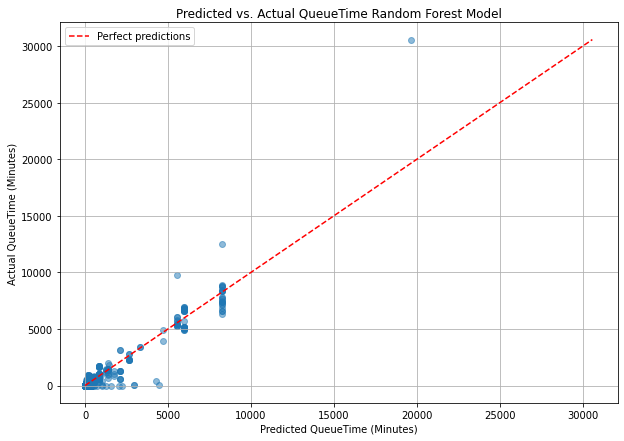

In [26]:
# Plotting both the identity line (for reference) and the scatter plot
plt.figure(figsize=(10, 7))  # Optional: you can adjust the figure size as needed

# Identity line for reference (where perfect predictions would lie)
array = np.arange(0, np.max([y_test.max(), y_pred.max()])+1)  # Adjust the range based on your data
plt.plot(array, array, 'r--', label='Perfect predictions')  # Red dashed line for reference

# Scatter plot of Predicted vs. Actual values
plt.scatter(y_pred, y_test, alpha=0.5)  # Alpha for marker opacity

# Adding title and axis labels
plt.title('Predicted vs. Actual QueueTime Random Forest Model')
plt.xlabel('Predicted QueueTime (Minutes)')
plt.ylabel('Actual QueueTime (Minutes)')

# Adding a legend
plt.legend()

# Show grid
plt.grid(True)

# saves figure to given location in directiory
plt.savefig('./Predicted_vs_Actual_QueueTime.png', format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

With that, our plot is complete!